# Projeto 1 - módulo 6

## Precificação dinâmica - e-commerce

### Mercari Price Suggestion Challenge - Kaggle

Mercari é um site de revenda de produtos online. Uma dos desafios desse tipo de plataforma é auxiliar o usuário, muitas vezes com pouco conhecimento de vendas, a determinar um preço para os seus produtos de modo a maximizar as chances de venda.

### Sobre este projeto

O presente projeto tem o objetivo de desenvolver um algoritmo que identifique produtos já vendidos similares e sugira ao usuário um preço ótimo para novos produtos cadastrados.


### Preparação do ambiente

Para este projeto, acesse o link https://www.kaggle.com/competitions/mercari-price-suggestion-challenge/overview 


In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.models import Model

!pip install tensorflow_addons
import tensorflow_addons as tfa
from sklearn import metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [95]:
base_train = pd.read_csv('/content/drive/MyDrive/Blue Edtech/data/processed/dados_treino.csv') 
base_test = pd.read_csv('/content/drive/MyDrive/Blue Edtech/data/processed/dados_teste.csv')
base_val = pd.read_csv('/content/drive/MyDrive/Blue Edtech/data/processed/dados_validacao.csv') 

In [4]:
base_test = pd.read_csv('/content/drive/MyDrive/Blue Edtech/data/processed/dados_teste.csv')

In [5]:
# preenchendo dados NAN

base_train['item_description'] = base_train['item_description'].fillna("No description")
base_train['name'] = base_train['name'].fillna(" ")

base_test['item_description'] = base_test['item_description'].fillna("No description")
base_test['name'] = base_test['name'].fillna(" ")

base_val['item_description'] = base_val['item_description'].fillna("No description")
base_val['name'] = base_val['name'].fillna(" ")

In [6]:
# unindo os atributos textuais buscando fortalecer a relação semântica entre eles

base_train['name_brand_description'] = base_train['name'] + ' ' + base_train['brand_name'] + ' ' + base_train['item_description']
base_test['name_brand_description'] = base_test['name'] + ' ' + base_test['brand_name'] + ' ' + base_test['item_description']
base_val['name_brand_description'] = base_val['name'] + ' ' + base_val['brand_name'] + ' ' + base_val['item_description']

In [104]:
# função de tokenização e preenchimento de comprimento

def text_vectorizer(feature):

  # TOKENIZAÇÃO
  tk = Tokenizer()

  # FIT ON TRAIN 
  tk.fit_on_texts(base_train[feature].apply(str))

  # TOKENIZANDO O DATASET DE TREINO
  tk_train = tk.texts_to_sequences(base_train[feature].apply(str))

  # TOKENIZANDO O DATASET DE TESTE
  tk_test = tk.texts_to_sequences(base_test[feature].apply(str))

  # TOKENIZANDO O DATASET DE VALIDAÇÃO
  tk_val = tk.texts_to_sequences(base_val[feature].apply(str))

  # COMPUTANDO O COMPRIMENTO MÁXIMO
  max_length = base_train[feature].apply(lambda x :len(str(x).split())).max()

  # COMPUTANDO O TAMANHO DO VOCABULÁRIO
  vocab_size = len(tk.word_index) + 1

  # PADDING A SEQUENCIA DE TREINO
  train_pad= pad_sequences(tk_train,padding="post",maxlen = max_length)

  # PADDING A SEQUENCIA DE TESTE
  test_pad = pad_sequences(tk_test,padding = "post", maxlen = max_length)

  # PADDING A SEQUENCIA DE TESTE
  val_pad = pad_sequences(tk_val,padding = "post", maxlen = max_length)

  # RETURNANDO O COMPRIMENTO MÁXIMO, SEQUÊNCIA PADDED DE TRAINO  , SEQUENCIA PADDED DE VALIDAÇÃO 
  return max_length, vocab_size, train_pad , test_pad, val_pad

In [8]:
# rodando a função text_vectorizer para todos os atributos

max_length_name_brand_description, vocab_size_name_brand_description, train_name_brand_description_pad , test_name_brand_description_pad, val_name_brand_description_pad = text_vectorizer('name_brand_description')
max_length_category_1, vocab_size_category_1, train_category_1_pad , test_category_1_pad, val_category_1_pad = text_vectorizer('category_1')
max_length_category_2, vocab_size_category_2, train_category_2_pad , test_category_2_pad, val_category_2_pad = text_vectorizer('category_2')
max_length_category_3, vocab_size_category_3, train_category_3_pad , test_category_3_pad, val_category_3_pad = text_vectorizer('category_3')

In [106]:
# separando treino e teste do atributo shipping

train_shipping = base_train.shipping
test_shipping = base_test.shipping
val_shipping = base_val.shipping

# separando treino e teste do atributo item_condition_id

train_item_cond = base_train.item_condition_id
test_item_cond = base_test.item_condition_id
val_item_cond = base_val.item_condition_id

In [10]:
# armazenando os dados em uma lista

x_train = [train_item_cond,train_shipping,train_category_1_pad,train_category_2_pad,train_category_3_pad,train_name_brand_description_pad]
x_test = [test_item_cond,test_shipping,test_category_1_pad, test_category_2_pad, test_category_3_pad,test_name_brand_description_pad]
x_val = [val_item_cond,val_shipping,val_category_1_pad, val_category_2_pad, val_category_3_pad,val_name_brand_description_pad]

In [108]:
# convertendo formato do atributo price para log

base_train['log_price'] = np.log(base_train['price'])
base_test['log_price'] = np.log(base_test['price'])

y_train = base_train.log_price
y_test = base_test.log_price

In [ ]:
# arquitetura do deep learning

tf.keras.backend.clear_session()
# ITEM CONDITION ID
inp1 = layers.Input(shape=(1)) # INPUT 1 
d1 = layers.Dense(10,activation="relu")(inp1) # DENSE LAYER 1
# SHIPPING 
inp2 = layers.Input(shape=(1)) # INPUT 2 
d2 = layers.Dense(10,activation="relu")(inp2) # DENSE LAYER 2
# CATEGORY_1
inp3 = layers.Input(shape = (3)) # INPUT 3
emb3 = layers.Embedding(vocab_size_category_1, 16, input_length= 3)(inp3) # EMBEDDING 4
flat3 = layers.Flatten()(emb3) # FLATTEN 
# CATEGORY_2
inp4 = layers.Input(shape = (5)) # INPUT 4
emb4 = layers.Embedding(vocab_size_category_2 , 16, input_length= 5)(inp4) # EMBEDDING 5
flat4 = layers.Flatten()(emb4) # FLATTEN
# CATEGORY_3
inp5= layers.Input(shape = (7)) # INPUT 5 
emb5 = layers.Embedding(vocab_size_category_3, 40, input_length= 7)(inp5) # EMBEDDING 6
flat5 = layers.Flatten()(emb5) # FLATTEN
# ITEM NAME_BRAND_DESCRIPTION
inp6= layers.Input(shape = (254)) # INPUT 6
emb6 = layers.Embedding(vocab_size_name_brand_description , 20 , input_length= 254 )(inp6) # EMBEDDING 8
lstm6 = layers.GRU(64,return_sequences=True)(emb6) # GRU
flat6 = layers.Flatten()(lstm6) # FLATTEN
# CONCATENAÇÃO
concat = layers.Concatenate()([d1,d2,flat3,flat4,flat5,flat6])
# DENSE LAYERS
dense1 = layers.Dense(512,activation="relu")(concat)
# DROPOUT LAYER
drop1 = layers.Dropout(0.1)(dense1)
# DENSE LAYER
dense2 = layers.Dense(256,activation="relu")(drop1)
# DROPOUT LAYER
drop2 = layers.Dropout(0.1)(dense2)
# DENSE LAYER
dense3 = layers.Dense(128,activation="relu")(drop2)
# BATCHNORM LAYER
bn2  = layers.BatchNormalization()(dense3)
# DENSE LAYER
dense4 = layers.Dense(1,activation="linear")(bn2)
# MODEL
model =  Model(inputs= [inp1,inp2,inp3,inp4,inp5,inp6],outputs=dense4)

# SCHEDULE
def shedule(epoch,lr):
    if epoch<=2:
        return lr
    else:
        return lr*0.1
# CALLBACKS
lr = tf.keras.callbacks.LearningRateScheduler(shedule,verbose=1)
save = tf.keras.callbacks.ModelCheckpoint("content/drive/MyDrive/Blue Edtech/notebooks",monitor="val_root_mean_squared_error",mode="min",save_best_only=True, save_weights_only=True,verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_root_mean_squared_error",min_delta= 0.01, patience=2,mode="min" )

model.compile(optimizer="adam",loss="mse",metrics=  [tf.keras.losses.MeanAbsoluteError(), tfa.metrics.r_square.RSquare(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.mean_absolute_percentage_error , tf.keras.metrics.mean_squared_logarithmic_error ])
model.summary()

In [112]:
# FITTING THE MODEL
history = model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=10, batch_size = 1024, callbacks=[save,lr,earlystop])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
911/912 [============================>.] - ETA: 0s - loss: 0.7066 - mean_absolute_error: 0.5430 - r_square: -0.1337 - root_mean_squared_error: 0.8406 - mean_absolute_percentage_error: 19.7180 - mean_squared_logarithmic_error: 0.0858
Epoch 1: val_root_mean_squared_error improved from inf to 0.48264, saving model to content/drive/MyDrive/Blue Edtech/notebooks
912/912 [==============================] - 64s 65ms/step - loss: 0.7063 - mean_absolute_error: 0.5428 - r_square: -0.1332 - root_mean_squared_error: 0.8404 - mean_absolute_percentage_error: 19.7146 - mean_squared_logarithmic_error: 0.0858 - val_loss: 0.2329 - val_mean_absolute_error: 0.3647 - val_r_square: 0.6254 - val_root_mean_squared_error: 0.4826 - val_mean_absolute_percentage_error: 13.1921 - val_mean_squared_logarithmic_error: 0.0157 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/10
9

In [113]:
# CRIANDO A FUNÇÃO DE CÁLCULO DAS MÉTRICAS

def print_avaliacao(obs, pred):
    print('R² = %.3f' % metrics.r2_score(obs, pred))
    print('MAPE = %.3f %%' % (100 * metrics.mean_absolute_percentage_error(obs, pred)))
    print('MAE = U$S %.2f' % (metrics.mean_absolute_error(obs, pred)))
    print('RMSE = U$S %.2f' % metrics.mean_squared_error(obs, pred)**0.5)
    print('RMSLE = %.4f' % metrics.mean_squared_log_error(obs, pred,squared=False))

In [116]:
# Predição e avaliação da amostra teste

y_pred = np.exp(model.predict(x_test))

12502/12502 [==============================] - 89s 7ms/step


In [117]:
print_avaliacao(base_test.price,y_pred)

R² = 0.539
MAPE = 34.460 %
MAE = U$S 9.95
RMSE = U$S 26.29
RMSLE = 0.4621


In [76]:
# Predição e avaliação da amostra de validação

y_pred_val = np.exp(model.predict(x_val))
print_avaliacao(base_val.price,y_pred_val)

4631/4631 [==============================] - 29s 6ms/step
R² = 0.285
MAPE = 34.364 %
MAE = U$S 10.22
RMSE = U$S 32.40
RMSLE = 0.4585


In [118]:
base_test['y_pred'] = y_pred

In [119]:
base_val['y_pred_val'] = y_pred_val

In [83]:
base_test.to_csv("resultados_test.csv")
base_val.to_csv('resultados_val.csv')

In [122]:
bias = (base_test['y_pred'] - base_test['price']).mean()

In [123]:
bias

-4.95867572786819

In [91]:
hist = (base_test['y_pred'] - base_test['price'])

In [55]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


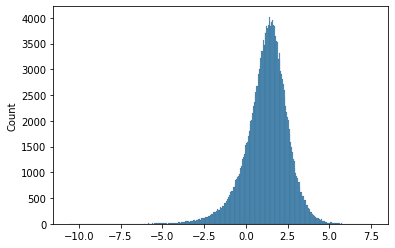

In [56]:
sns.histplot(np.log(hist))

In [92]:
from scipy import stats

In [93]:
k, p = stats.normaltest(hist)

In [94]:
p

0.0

Como valor de p é 0 isto significa dizer que a distribuição é normal e portanto o viés não é estatisticamente significante.

In [19]:
# Venda seu produto!

# produto = int(input('Digite índice do produto cadastrado: \n'))
# select = (base_test.index == produto)
# produto_cadastrado = base_test[select]
# produto_cadastrado[['name', 'category_1', 'category_2', 'category_3', 'item_description', 'item_condition_id', 'brand_name', 'price']]

In [20]:
# item_selecionado = [x_test[0][select],x_test[1][select],x_test[2][select],x_test[3][select],x_test[4][select],x_test[5][select],x_test[6][select],x_test[7][select]]

In [21]:
# Valor sugerido

# preco_sugerido = float(np.exp(model.predict(item_selecionado)))
# print(f' Sugerimos um valor entre U${np.round(preco_sugerido*0.8,2)} e U${np.round(preco_sugerido*1.2,2)}, um preço ideal seria U${np.round(preco_sugerido,2)}')

Visualização da arquitetura da rede

### Referência

https://github.com/pushapgandhi/Mercari_Price_Prediction/blob/main/Deep_Learning_Model.ipynb

https://towardsdatascience.com/mercari-price-prediction-challenge-3a8ea00a7d33

